# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [125]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: -2.466987
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** The loss is equal to approximately -log(probability). Because there are 10 total classes, the probability that a random guesser correctly predicts an image is 1/10, or 0.1.


In [135]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.838490 analytic: 0.838490, relative error: 1.407484e-08
numerical: -1.041059 analytic: -1.041059, relative error: 8.979335e-09
numerical: -1.420837 analytic: -1.420837, relative error: 2.413466e-08
numerical: 1.913122 analytic: 1.913122, relative error: 5.889929e-08
numerical: -1.323568 analytic: -1.323568, relative error: 2.969759e-08
numerical: -0.729494 analytic: -0.729494, relative error: 1.208241e-08
numerical: 2.216259 analytic: 2.216259, relative error: 2.483090e-09
numerical: 0.833948 analytic: 0.833947, relative error: 2.077128e-08
numerical: -0.118165 analytic: -0.118165, relative error: 5.937400e-07
numerical: 0.527339 analytic: 0.527339, relative error: 2.959274e-08
numerical: -0.446960 analytic: -0.446960, relative error: 8.916356e-08
numerical: 3.103209 analytic: 3.103209, relative error: 1.055835e-08
numerical: 0.279332 analytic: 0.279332, relative error: 9.938720e-08
numerical: -0.345057 analytic: -0.345057, relative error: 2.184491e-08
numerical: -0.689896

In [198]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.342508e+00 computed in 0.096424s
vectorized loss: 2.342508e+00 computed in 0.004362s
Loss difference: 0.000000
Gradient difference: 0.000000


In [201]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iters = 500
# loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
learning_rate_range = np.logspace(-8, 1, 10)
reg_range = np.logspace(-2, 5, 10)

for learning_rate in learning_rate_range:
    for reg in reg_range:
        softmax_test = Softmax()
        loss_hist = softmax_test.train(X_train, y_train, learning_rate = learning_rate, reg = reg, num_iters = iters, verbose=False)
        #print("Learning rate: {}; reg: {}; loss: {}".format(learning_rate, reg, loss_hist[-1]))
        
        y_train_pred = softmax_test.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        
        y_val_pred = softmax_test.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax_test
        
        print("learning rate: {}, reg: {}.\ntraining_acc: {}, valid_acc: {}".format(learning_rate, reg, training_accuracy, validation_accuracy))

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning rate: 1e-08, reg: 0.01.
training_acc: 0.13089795918367347, valid_acc: 0.126
learning rate: 1e-08, reg: 0.05994842503189409.
training_acc: 0.12120408163265306, valid_acc: 0.091
learning rate: 1e-08, reg: 0.35938136638046275.
training_acc: 0.133, valid_acc: 0.129
learning rate: 1e-08, reg: 2.1544346900318843.
training_acc: 0.13453061224489796, valid_acc: 0.128
learning rate: 1e-08, reg: 12.91549665014884.
training_acc: 0.11597959183673469, valid_acc: 0.136
learning rate: 1e-08, reg: 77.4263682681127.
training_acc: 0.10793877551020409, valid_acc: 0.105
learning rate: 1e-08, reg: 464.1588833612782.
training_acc: 0.1306734693877551, valid_acc: 0.129
learning rate: 1e-08, reg: 2782.559402207126.
training_acc: 0.11059183673469387, valid_acc: 0.126
learning rate: 1e-08, reg: 16681.005372000593.
training_acc: 0.1386734693877551, valid_acc: 0.118
learning rate: 1e-08, reg: 100000.0.
training_acc: 0.11022448979591837, valid_acc: 0.113
learning rate: 1e-07, reg: 0.01.
training_acc: 0.2115

/Users/kfang/Desktop/CS4/linear/cs231n/classifiers/softmax.py:89: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(correct_probs)) / num_train
/Users/kfang/Desktop/CS4/linear/cs231n/classifiers/softmax.py:85: RuntimeWarning: overflow encountered in exp
  probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
/Users/kfang/Desktop/CS4/linear/cs231n/classifiers/softmax.py:85: RuntimeWarning: invalid value encountered in true_divide
  probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)


learning rate: 0.0001, reg: 16681.005372000593.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.0001, reg: 100000.0.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 0.01.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 0.05994842503189409.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 0.35938136638046275.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 2.1544346900318843.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 12.91549665014884.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 77.4263682681127.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 464.1588833612782.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 2782.559402207126.
training_acc: 0.10026530612244898, valid_acc: 0.087
learning rate: 0.001, reg: 16681.00

In [202]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.367000


In [207]:
# learning rate: 1e-06, reg: 16681.005372000593

best_softmax = Softmax()
loss_hist = best_softmax.train(X_train, y_train, learning_rate=1e-06, reg=16681, num_iters=2000, verbose=True)

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

iteration 100 / 2000: loss 261.013040
iteration 200 / 2000: loss 10.688400
iteration 300 / 2000: loss 2.312630
iteration 400 / 2000: loss 1.967775
iteration 500 / 2000: loss 2.033503
iteration 600 / 2000: loss 2.054055
iteration 700 / 2000: loss 1.985848
iteration 800 / 2000: loss 1.967599
iteration 900 / 2000: loss 1.961006
iteration 1000 / 2000: loss 1.945671
iteration 1100 / 2000: loss 2.022966
iteration 1200 / 2000: loss 2.080688
iteration 1300 / 2000: loss 2.013340
iteration 1400 / 2000: loss 2.017384
iteration 1500 / 2000: loss 2.005915
iteration 1600 / 2000: loss 1.971927
iteration 1700 / 2000: loss 1.979734
iteration 1800 / 2000: loss 2.012324
iteration 1900 / 2000: loss 2.017865
iteration 2000 / 2000: loss 2.014774
softmax on raw pixels final test set accuracy: 0.360000


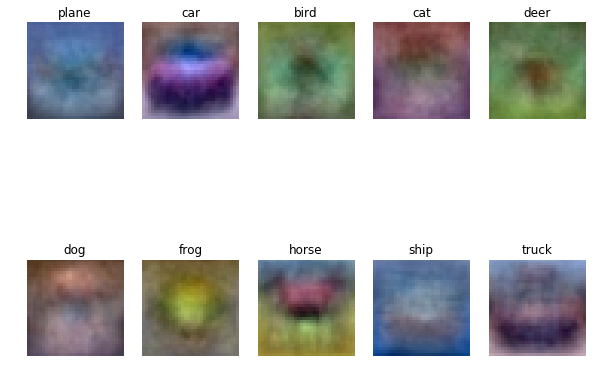

In [208]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])